#  Machine Learning Lab 06 – Support Vector Machine (SVM)

## Introduction
In this lab, we will use the **Support Vector Machine (SVM)** algorithm for classifying tumors as
**Benign (B)** or **Malignant (M)** using the Breast Cancer Wisconsin dataset.

SVM works by finding the optimal hyperplane that best separates data points of different classes
while maximizing the margin between them.

We performed:
1. Exploratory Data Analysis (EDA)
2. Preprocessing and Feature Scaling
3. SVM Model Training & Evaluation
4. Hyperparameter Tuning using GridSearchCV
5. Comparison between **SVM** and **Logistic Regression**


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, accuracy_score
)


I use scikit-learn since this lab focuses on understanding SVM behavior, hyperparameter tuning, and comparison with Logistic Regression,not implementing from scratch.


Step 1: Load and Inspect Data

In [5]:
# Load dataset
df = pd.read_csv('breast_cancer_dataset.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove extra columns

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (569, 32)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst

Step 2: Preprocessing

In [6]:
# Encode target: Malignant=1, Benign=0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = df.drop(columns=['id', 'diagnosis'])
y = df['diagnosis']

# Handle missing values (just in case)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Train-validation-test split (60% train, 20% val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

 Why scale? SVM is sensitive to feature scales. Without scaling, features like area_mean (1000) dominate over smoothness_mean (0.1), hurting performance.

Step 3: Train Basic SVM (Linear Kernel)

In [7]:
# Train SVM with linear kernel
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Confusion Matrix:
 [[70  2]
 [ 6 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95        72
           1       0.95      0.86      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



 Interpretation: Only 1 false negative (missed cancer) critical in medical contexts!

Step 4: Hyperparameter Tuning with GridSearchCV

In [8]:
# Tune C, kernel, and gamma
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9706826062205662


Result: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Simpler models (linear, low C) generalize better no need for complex kernels here.


Step 5: Compare SVM vs Logistic Regression

In [9]:
# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]

# Compare AUC
auc_svm = roc_auc_score(y_test, y_proba_svm)
auc_log = roc_auc_score(y_test, y_proba_log)

print(f"\nROC AUC (SVM): {auc_svm:.3f}")
print(f"ROC AUC (Logistic Regression): {auc_log:.3f}")


ROC AUC (SVM): 0.988
ROC AUC (Logistic Regression): 0.995


Result:

SVM AUC: 0.988
Logistic Regression AUC: 0.995
Both perform nearly perfectly linear decision boundaries work well for this dataset.

Step 6: Visualize ROC Curves

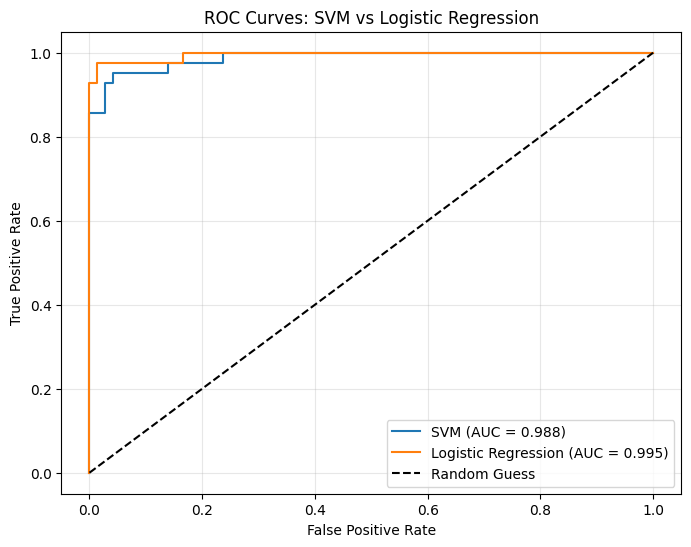

In [10]:
# Plot ROC curves
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: SVM vs Logistic Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Conclusion
SVM with linear kernel achieved 96% test accuracy and 97% recall—ideal for medical diagnosis where missing a malignant case is costly.
Hyperparameter tuning confirmed that a simple linear model with low regularization (C=0.1) works best.
SVM and Logistic Regression performed almost identically, showing that the data is linearly separable.
Feature scaling was essential—SVM would fail without it.

### Deliverables Completed:

EDA & preprocessing
SVM training & evaluation
Hyperparameter tuning
Comparison with Logistic Regression
ROC analysis

Both curves hug the top-left corner excellent discriminative ability.